In [1]:
#import packages
import pandas as pd
import os
import glob
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

## Data Prep

In [2]:
# create a local path, and pull .csv files into a list 'df'

path = r'/Users/spencersu/Desktop/JCPS Efficacy Report/Datasets'

all_files = glob.glob(path + "/JeffCo 8th Grade for Scoring*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

In [3]:
# grade 8 file has a different first row than the other files
li[1].columns = li[1].iloc[0]

li[1] = li[1].iloc[1:,:]

# grade 4 already has a grade_level column
li[2].columns = li[0].columns

# change all subtype column to a name "subtype"
for num in range(0,9):
    li[num].rename(columns={li[num].columns[2]: "subtype" }, inplace = True)

In [4]:
# create a function to add a column suggesting grade level 
def unify_col(grade_level, number):
    li[number].insert(7, 'student_grade_level', grade_level)
    li[number].columns = li[0].columns

In [5]:
unify_col(8,1)
unify_col(10,3)
unify_col(12,4)
unify_col(9,5)
unify_col(6,6)
unify_col(7,7)
unify_col(11,8)

In [6]:
df = pd.concat(li, axis=0, ignore_index=True)

In [7]:
## drop na for the framework columns 
c = df.iloc[:, 10:17].columns 
df = df.dropna(subset=c, how='any')

In [8]:
## import word count data and merge to the existing dataset

wordcount = pd.read_csv(os.path.join(path,'JeffCo word count 19-22.csv'))
wordcount.rename(columns={'Student Assignment ID':'id'}, inplace=True)

# convert word count into intergers
wordcount = wordcount.dropna(subset=['Word Count'])
wordcount['Word Count'].replace(',','',regex=True,inplace=True)
wordcount['Word Count'] = wordcount['Word Count'].astype(int)
wordcount2 = wordcount.groupby('id')['Word Count'].mean()

# merge wordcount and df # only keep columns student assignment ID and word count for merging
df2 = pd.merge(df, wordcount2, on=['id'], how='inner')

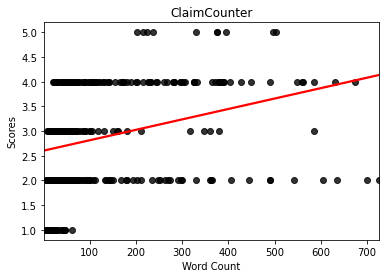

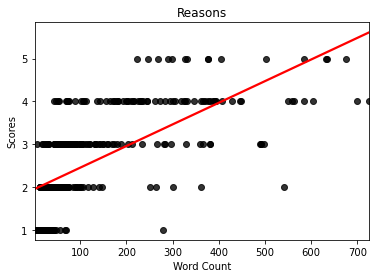

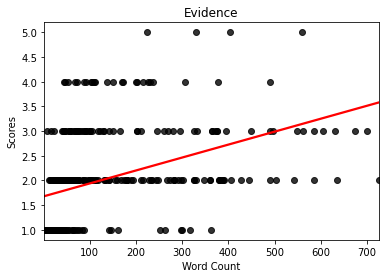

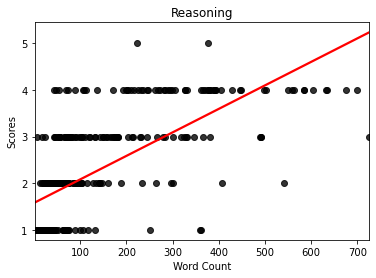

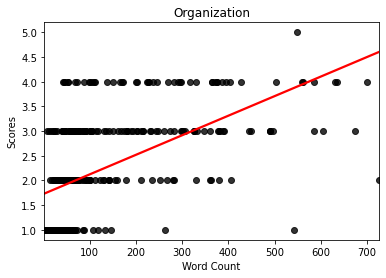

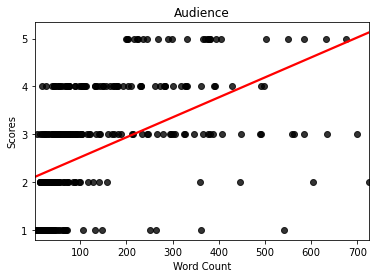

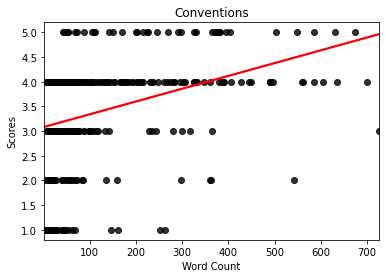

In [17]:
for category in df2.columns[10:17]:
    sns.regplot(df2['Word Count'],df2[category],
                scatter_kws={"color": "black"}, line_kws={"color": "red"}, ci=None)
    plt.xlabel('Word Count')
    plt.ylabel('Scores')
    plt.title(category)
    plt.show()

In [23]:
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=5000
# Min and max degree of polynomials features to consider
degree_min = 1
degree_max = 2 #8
# for the sake of running speed, running the results from degree 1 to 8 shows that 
# 1st degree has the highest RMSE, 2nd degree has the highest test score 


# get dummy variables for the string variables
for category in df2.columns[10:17]:
    df2[category] = df2[category].astype(int)
df3 = pd.get_dummies(df2.iloc[:,[2,3,4,7,10,11,12,13,14,15,16,17]])

# drop all the claims 
X = df3.drop(df3.iloc[:,1:8],axis=1)

# Test/train split
for category in df2.columns[10:17]:
    X_train, X_test, y_train, y_test = train_test_split(X,df2[category], test_size=0.2)
    
    # Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
    for degree in range(degree_min,degree_max+1):
        model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), 
                              LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,normalize=True,cv=5))
        model.fit(X_train,y_train)
        test_pred = np.array(model.predict(X_test))
        RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
        test_score = model.score(X_test,y_test)
        print(category, ": degree =", degree, ", and RMSE =", RMSE)
        print(category, ": degree =", degree, ", and test score =", test_score)

ClaimCounter : degree = 1 , and RMSE = 6.788718277150429
ClaimCounter : degree = 1 , and test score = 0.3204374607082049
ClaimCounter : degree = 2 , and RMSE = 6.20445661230678
ClaimCounter : degree = 2 , and test score = 0.43237520054427536
Reasons : degree = 1 , and RMSE = 6.2974550495009884
Reasons : degree = 1 , and test score = 0.5178810008045602
Reasons : degree = 2 , and RMSE = 5.628794529354994
Reasons : degree = 2 , and test score = 0.614827843370053
Evidence : degree = 1 , and RMSE = 6.842733461112916
Evidence : degree = 1 , and test score = 0.3403803456757596
Evidence : degree = 2 , and RMSE = 5.82354038369449
Evidence : degree = 2 , and test score = 0.5222413891922396
Reasoning : degree = 1 , and RMSE = 6.7929167839269855
Reasoning : degree = 1 , and test score = 0.4439500791306267
Reasoning : degree = 2 , and RMSE = 5.816168489337266
Reasoning : degree = 2 , and test score = 0.5923615393171914
Organization : degree = 1 , and RMSE = 5.208001966649431
Organization : degree =

In [24]:
for category in df3.columns[1:8]:
    Y = df3[category]
    model = sm.OLS(Y, X).fit()
    predictions = model.predict(X) 
    print_model = model.summary()
    print(print_model)

                            OLS Regression Results                            
Dep. Variable:           ClaimCounter   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     7.364
Date:                Tue, 25 Jan 2022   Prob (F-statistic):           4.04e-19
Time:                        21:57:49   Log-Likelihood:                -403.31
No. Observations:                 329   AIC:                             856.6
Df Residuals:                     304   BIC:                             951.5
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [25]:
# maybe we need to separate the degree test on all variables, and just test it on word count